<a href="https://colab.research.google.com/github/disha2sinha/Movie-Recommendation-System/blob/master/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES:**

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
!pip install rake_nltk
from rake_nltk import Rake 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#https://drive.google.com/file/d/1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3/view?usp=sharing

In [3]:
id='1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MoviesData.csv')  
movies_data = pd.read_csv('MoviesData.csv',engine='python',index_col=0)
movies_data.head()

,title,release_year,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating
0,Se7en,1995,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,18.457430,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926
1,Batman,1989,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,19.106730,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015
2,The Empire Strikes Back,1980,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,19.470959,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975
3,Drag Me to Hell,2009,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,15.809588,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246
4,Suspect,1987,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,10.638289,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098


# **POPULARITY BASED RECOMMENDATION SYSTEM :**

In [4]:
movies_data[['vote_count','vote_average','rating_count','mean_rating','popularity']].describe()

,vote_count,vote_average,rating_count,mean_rating,popularity
count,45663.000000,45663.000000,45663.000000,45663.000000,45663.000000
mean,109.588179,5.617947,484.200666,0.771628,2.922354
std,490.228641,1.924399,2943.748802,1.389116,5.996711
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,0.000000,0.000000,0.386454
50%,10.000000,6.000000,0.000000,0.000000,1.129126
75%,34.000000,6.800000,0.000000,0.000000,3.685682
max,14075.000000,10.000000,91921.000000,5.000000,547.488298


**WEIGHTED AVERAGE FOR EACH MOVIES AVERAGE RATINGS :**

Weighted Ratings: 
>              W =   Rv + Cm
>                   ---------
                     v+m

R= average rating for the movie as a number from 0 to 10

v= number of votes for the movie

m= minimum votes required to be listed in Top(here 2000)

C=the mean vote across whole report


In [5]:
R=movies_data['vote_average']
v=movies_data['vote_count']
C=movies_data['vote_average'].mean()
m=2000

In [6]:
movies_data['weighted_votes']=(R*v+C*m)/(v+m)
movies_data[['title','weighted_votes']].sort_values('weighted_votes',ascending=False).head(20)

,title,weighted_votes
67,The Shawshank Redemption,7.943512
1555,The Dark Knight,7.924073
2120,Fight Club,7.840666
2130,Pulp Fiction,7.797272
6075,Inception,7.791191
9040,The Godfather,7.781642
33564,Interstellar,7.723561
109,Forrest Gump,7.691071
2594,The Lord of the Rings: The Return of the King,7.614560
1942,The Lord of the Rings: The Fellowship of the Ring,7.562605


In [7]:
R1=movies_data['mean_rating']
v1=movies_data['rating_count']
C1=movies_data['mean_rating'].mean()
m1=movies_data['rating_count'].quantile(0.95)
m1

1643.9000000000015

In [8]:
movies_data['weighted_ratings']=(R1*v1+C1*m1)/(v1+m1)
movies_data[['title','weighted_ratings']].sort_values('weighted_ratings',ascending=False).head(20)

,title,weighted_ratings
1,Batman,4.364174
19,Three Days of the Condor,4.239907
15,Maze Runner: The Scorch Trials,4.204964
7,Dracula Untold,4.183633
13,Far from Heaven,4.138506
63,The Truman Show,4.113689
2,The Empire Strikes Back,4.107587
47,Street Kings,4.092986
3,Drag Me to Hell,4.087415
4,Suspect,4.084247


**ASSIGNING SCORES TO THE MOVIES BY GIVING 45% IMPORTANCE TO WEIGHTED AVERAGE OF VOTES + 45% IMPORTANCE TO POPULARITY + 10% TO WEIGHTED AVERAGE OF RATINGS**

In [9]:
scaler=MinMaxScaler()
movies_data[['weighted_votes','weighted_ratings','popularity']]=scaler.fit_transform(movies_data[['weighted_votes','weighted_ratings','popularity']])
movies_data['score']=movies_data['weighted_votes']*0.45 + movies_data['weighted_ratings']*0.1+movies_data['popularity']*0.45
movies_data[['title','weighted_votes','weighted_ratings','popularity','score']].sort_values('score',ascending=False).head(10)

,title,weighted_votes,weighted_ratings,popularity,score
27517,Minions,0.404024,0.000274,1.000000,0.631838
9,Wonder Woman,0.599344,0.846461,0.537613,0.596277
1555,The Dark Knight,0.993477,0.356847,0.224968,0.583985
2130,Pulp Fiction,0.950925,0.375564,0.257449,0.581325
67,The Shawshank Redemption,1.000000,0.757741,0.094332,0.568223
1609,Big Hero 6,0.775159,0.377674,0.390602,0.562360
116,Guardians of the Galaxy Vol. 2,0.690749,0.807078,0.338511,0.543875
328,Deadpool,0.728643,0.580056,0.343132,0.540304
131,Beauty and the Beast,0.510901,0.645611,0.524675,0.530570
1218,Gone Girl,0.794494,0.454052,0.282748,0.530164


**ONLY MOVIES HAVING SCORE ABOVE A THRESHOLD VALUE CONSIDERED POPULAR :**

In [10]:
movies_data.score.describe()

count    45663.000000
mean         0.110041
std          0.030936
min          0.030931
25%          0.099160
50%          0.100148
75%          0.104319
max          0.631838
Name: score, dtype: float64

In [11]:
movies_data[movies_data['score']>=0.0992].movieId.count()

33593

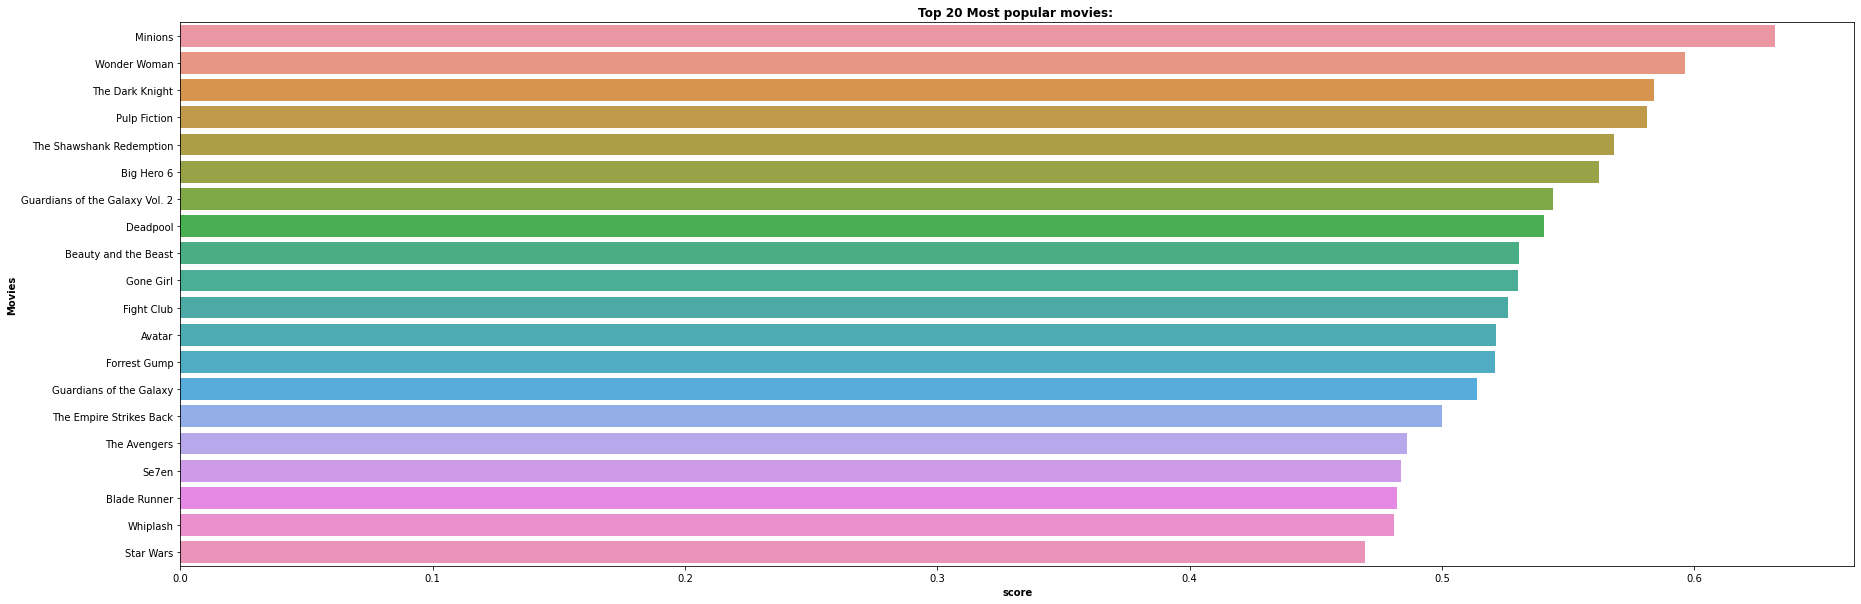

In [12]:
popular_movies=movies_data[movies_data['score']>=0.0992]
popular_movies=popular_movies[['movieId','title','budget','profit','score','release_year','release_day','genres','production_countries','production_companies','original_language','runtime','content','status','cast','director']].sort_values('score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(30,10))
axis=sns.barplot(x=popular_movies['score'].head(20),y=popular_movies['title'].head(20))
plt.title('Top 20 Most popular movies: ',weight='bold')
plt.xlabel('score',weight='bold')
plt.ylabel('Movies',weight='bold')
plt.savefig('PopularMovies.jpg')

In [13]:
popular_movies.shape

(33593, 16)

In [14]:
popular_movies.head()

,movieId,title,budget,profit,score,release_year,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director
0,135887,Minions,74000000,1.082731e+09,0.631838,2015,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,2017,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,2008,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan
3,296,Pulp Fiction,8000000,2.059288e+08,0.581325,1994,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino
4,318,The Shawshank Redemption,25000000,3.341469e+06,0.568223,1994,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont


**IMPORTING USER_RATINGS DATASET:**

In [15]:
#https://drive.google.com/file/d/1nVaAmYBm8xnDR8ynF9eX0qY06_c5ZzqG/view?usp=sharing
id='1nVaAmYBm8xnDR8ynF9eX0qY06_c5ZzqG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('RevisedRatings.csv')  
user_ratings = pd.read_csv('RevisedRatings.csv',engine='python',index_col=0)
user_ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


**FILTERING USERS BY THE NUMBER OF RATINGS THEY GAVE:**Users who gave less than 60 ratings are discarded.

In [16]:
user_numberOfRatings=pd.DataFrame(user_ratings.groupby('userId')['rating'].count()).rename(columns={'rating':'count_rating'})
user_numberOfRatings=user_numberOfRatings[user_numberOfRatings['count_rating']>60]
len(user_numberOfRatings)

91137

In [17]:
user_ratings.shape

(26024289, 3)

In [18]:
users_movies=pd.merge(user_ratings,popular_movies[['movieId','title']],how='inner',on='movieId')
selectedusers=user_numberOfRatings.index.values.tolist()
final_ratings=users_movies.query('userId in @selectedusers')
final_ratings.shape

(21721263, 4)

In [19]:
final_ratings.head()

,userId,movieId,rating,title
1,11,110,3.5,Braveheart
3,24,110,5.0,Braveheart
5,30,110,5.0,Braveheart
7,34,110,5.0,Braveheart
8,49,110,4.0,Braveheart


# **CONTENT - BASED RECOMMENDATION SYSTEM ON POPULAR MOVIES**

**KEY WORDS FOR EACH MOVIE :**

In [20]:
popular_movies['keywords']=popular_movies['cast'].apply(str)+" "+popular_movies['production_companies'].apply(str)+" "+popular_movies['production_countries'].apply(str)+" "+popular_movies['content'].apply(str)+" "+popular_movies['genres'].apply(str)+" "+popular_movies['director'].apply(str)+" "+popular_movies['release_day'].apply(str)+" "+popular_movies['budget'].apply(str)+" "+popular_movies['profit'].apply(str)+" "+popular_movies['runtime'].apply(str)+" "+popular_movies['status'].apply(str)+" "+popular_movies['original_language'].apply(str)
popular_movies['important_words']=""
for index,row in popular_movies.iterrows():
  keywords=row['keywords']
  r=Rake()
  r.extract_keywords_from_text(keywords)
  keywords_scores=r.get_word_degrees()
  popular_movies.at[index,'important_words']=list(keywords_scores.keys())


In [21]:
popular_movies['important_words']=[','.join(map(str,word)) for word in popular_movies['important_words']]
popular_movies.drop('keywords',inplace=True,axis=1)
popular_movies.head()

,movieId,title,budget,profit,score,release_year,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,important_words
0,135887,Minions,74000000,1.082731e+09,0.631838,2015,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda,"michael,keaton,bad,bosses,family,inventor,husb..."
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,2017,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins,"greatest,jag,patel,muller,saïd,taghmaoui,joset..."
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,2008,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan,"joker,richard,divizio,vincenzo,nicoli,gertrude..."
3,296,Pulp Fiction,8000000,2.059288e+08,0.581325,1994,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino,"crime,quentin,tarantino,saturday,8000000,20592..."
4,318,The Shawshank Redemption,25000000,3.341469e+06,0.568223,1994,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont,"william,sadler,drama,gil,bellows,neil,giuntoli..."


In [22]:
popular_movies['release_year'].min()

'1874'

In [23]:
popular_movies[popular_movies['release_year']==''].shape[0]

0

### **DIVIDING DATASET INTO SMALLER DATASETS ACCORDING TO THEIR YEAR OF RELEASE**

## **POPULAR MOVIES RELEASED BETWEEN YEAR 2000 AND YEAR 2020**

In [24]:
popular_movies2000_2020=popular_movies[(popular_movies['release_year']>='2000')&(popular_movies['release_year']<='2020')]
popular_movies2000_2020.drop('release_year',inplace=True,axis=1)
print("There are {} movies in the dataset that released between 2010-2020".format(popular_movies2000_2020.shape[0]))
popular_movies2000_2020.head()

There are 18283 movies in the dataset that released between 2010-2020


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,movieId,title,budget,profit,score,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,important_words
0,135887,Minions,74000000,1.082731e+09,0.631838,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda,"michael,keaton,bad,bosses,family,inventor,husb..."
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins,"greatest,jag,patel,muller,saïd,taghmaoui,joset..."
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan,"joker,richard,divizio,vincenzo,nicoli,gertrude..."
5,115617,Big Hero 6,165000000,4.871054e+08,0.562360,Friday,Adventure|Family|Animation|Action|Comedy,United States of America,Walt Disney Pictures|Walt Disney Animation Stu...,English,102.0,The special bond that develops between plus-si...,Released,Scott Adsit|Ryan Potter|Daniel Henney|T.J. Mil...,Chris Williams,"norris,frozen,adventure,marlie,crisafulli,prod..."
6,122918,Guardians of the Galaxy Vol. 2,200000000,6.634161e+08,0.543875,Wednesday,Action|Adventure|Comedy|Science Fiction,United States of America,Walt Disney Pictures|Marvel Studios,English,137.0,The Guardians must fight to keep their newfoun...,Released,Chris Pratt|Zoe Saldana|Dave Bautista|Vin Dies...,James Gunn,"michael,rooker,milynn,sarley,josh,tipis,qen,qu..."


In [25]:
tf=TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',ngram_range=(1,3),stop_words='english')
tvf_matrix2000_2020=tf.fit_transform(popular_movies2000_2020['important_words'])

In [26]:
tvf_matrix2000_2020.shape

(18283, 101405)

In [27]:
cosine_sim2000_2020=cosine_similarity(tvf_matrix2000_2020,tvf_matrix2000_2020)

## **PAIRWISE SIMILARITY FOR THE MOVIES RELEASED BETWEEN 2000 AND 2020**

In [28]:
cosine_sim2000_2020df=pd.DataFrame(cosine_sim2000_2020,index=popular_movies2000_2020.title,columns=popular_movies2000_2020.title)
cosine_sim2000_2020df.head()

title,Minions,Wonder Woman,The Dark Knight,Big Hero 6,Guardians of the Galaxy Vol. 2,Deadpool,Beauty and the Beast,Gone Girl,Avatar,Guardians of the Galaxy,The Avengers,Whiplash,Baby Driver,The Lord of the Rings: The Return of the King,Inception,Django Unchained,The Lord of the Rings: The Fellowship of the Ring,Interstellar,The Martian,John Wick,Captain America: Civil War,Logan,Inside Out,V for Vendetta,The Intouchables,Up,The Lord of the Rings: The Two Towers,Finding Nemo,Harry Potter and the Deathly Hallows: Part 2,Captain America: The Winter Soldier,Harry Potter and the Chamber of Secrets,The Wolf of Wall Street,Spirited Away,Harry Potter and the Goblet of Fire,Star Wars: The Force Awakens,Zootopia,Avengers: Age of Ultron,Batman Begins,Gladiator,The Hunger Games: Mockingjay - Part 1,...,Şevkat Yerimdar,Roboshark,The Day the '60s Died,Planet B-Boy,Back to School with Franklin,The Subtenant,Charlotte's Web 2: Wilbur's Great Adventure,Savage,Hori Smoku Sailor Jerry,Higglety Pigglety Pop! or There Must Be More to Life,Dura,Gloriously Wasted,Hannah Free,Voices from the List,María (y los demás),True Blue,Blood Money,Adventures of a Teenage Dragonslayer,Pablo's Hippos,The Pyramid,Dark Streets,The Assailant,Cleopatra,Thomas in Love,My Little Pony: Equestria Girls - Friendship Games,The Pink Floyd and Syd Barrett Story,Zidane - A 21st Century Portrait,Rogue River,Eminem AKA,Used Parts,Cinematographer Style,Hôtel Normandy,Amongst White Clouds,Blowfish,Deadline,Midgets Vs. Mascots,Stacy: Attack of the Schoolgirl Zombies,Two Shots Fired,3 Braves,Bad Family
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Minions,1.000000,0.013594,0.014327,0.015399,0.027947,0.016640,0.022143,0.010985,0.027083,0.015275,0.017081,0.012164,0.029555,0.008898,0.010194,0.020068,0.007611,0.010072,0.015507,0.011802,0.017268,0.016890,0.022438,0.008741,0.004473,0.051685,0.007309,0.072004,0.014374,0.021870,0.014021,0.019472,0.010680,0.008802,0.022865,0.017304,0.009318,0.013316,0.028773,0.009499,...,0.002922,0.005056,0.010387,0.010077,0.012899,0.002822,0.022743,0.003507,0.014842,0.007202,0.000441,0.001215,0.006605,0.006661,0.007912,0.004511,0.018281,0.016507,0.014289,0.001004,0.006334,0.004362,0.002304,0.016206,0.009185,0.009465,0.001910,0.010307,0.001080,0.005430,0.022057,0.006937,0.002078,0.002730,0.002459,0.003649,0.002716,0.001476,0.020260,0.010557
Wonder Woman,0.013594,1.000000,0.041869,0.020962,0.023174,0.028669,0.047775,0.023619,0.027562,0.024085,0.028262,0.013235,0.028882,0.025592,0.027076,0.021882,0.018217,0.038004,0.021140,0.035064,0.044882,0.026544,0.021791,0.038091,0.010366,0.010788,0.021533,0.010128,0.042189,0.038628,0.045351,0.029945,0.009680,0.038237,0.026451,0.022306,0.027063,0.062449,0.035985,0.020048,...,0.000277,0.011905,0.004857,0.008026,0.012171,0.001758,0.014254,0.004162,0.004082,0.033663,0.000238,0.000656,0.018086,0.002810,0.010556,0.007812,0.009632,0.009753,0.015579,0.005613,0.010412,0.005650,0.000219,0.002313,0.011176,0.010787,0.004514,0.007086,0.009260,0.001622,0.008280,0.001480,0.007041,0.012132,0.000143,0.000997,0.000742,0.006018,0.011034,0.000142
The Dark Knight,0.014327,0.041869,1.000000,0.026016,0.035290,0.022743,0.036168,0.031016,0.040026,0.036850,0.030756,0.026128,0.037160,0.018959,0.078350,0.042053,0.019101,0.054112,0.020243,0.040891,0.036338,0.038098,0.021373,0.056446,0.011359,0.008963,0.021465,0.013738,0.042176,0.040868,0.031574,0.031892,0.000115,0.037803,0.039403,0.028803,0.023158,0.129858,0.019136,0.024875,...,0.000240,0.038076,0.010716,0.014739,0.003424,0.000232,0.007614,0.002926,0.003536,0.015366,0.000812,0.002563,0.012316,0.000756,0.000640,0.014231,0.018068,0.009374,0.005879,0.008277,0.014125,0.008458,0.000745,0.004711,0.005851,0.010700,0.005399,0.008733,0.012125,0.006291,0.008249,0.004596,0.000972,0.015856,0.005314,0.008474,0.000643,0.002780,0.007119,0.000483
Big Hero 6,0.015399,0.020962,0.026016,1.000000,0.063632,0.046060,0.046316,0.035931,0.022984,0.041595,0.042818,0.029784,0.018597,0.

## **POPULAR MOVIES THAT RELEASED BETWEEN 1970 AND 2000**

In [29]:
popular_movies1970_2000=popular_movies[(popular_movies['release_year']>='1970')&(popular_movies['release_year']<'2000')]
popular_movies1970_2000.drop('release_year',inplace=True,axis=1)
print("There are {} movies in the dataset that released between 1970-2000".format(popular_movies1970_2000.shape[0]))
popular_movies1970_2000.head()

There are 9503 movies in the dataset that released between 1970-2000


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,movieId,title,budget,profit,score,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,important_words
3,296,Pulp Fiction,8000000,205928762.0,0.581325,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino,"crime,quentin,tarantino,saturday,8000000,20592..."
4,318,The Shawshank Redemption,25000000,3341469.0,0.568223,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont,"william,sadler,drama,gil,bellows,neil,giuntoli..."
10,2959,Fight Club,63000000,37853753.0,0.526088,Friday,Drama,Germany|United States of America,Twentieth Century Fox Film Corporation|Regency...,English,139.0,A ticking-time-bomb insomniac and a slippery s...,Released,Edward Norton|Brad Pitt|Meat Loaf|Jared Leto|H...,David Fincher,"paul,carafotes,bob,stephenson,0,139,van,quattr..."
12,356,Forrest Gump,55000000,622945399.0,0.521140,Wednesday,Comedy|Drama|Romance,United States of America,Paramount Pictures,English,142.0,A man with a low IQ has accomplished great thi...,Released,Tom Hanks|Robin Wright|Gary Sinise|Mykelti Wil...,Robert Zemeckis,"courage,haley,joel,osment,jacqueline,lovell,mi..."
14,1196,The Empire Strikes Back,18000000,520400000.0,0.500092,Saturday,Adventure|Action|Science Fiction,United States of America,Lucasfilm|Twentieth Century Fox Film Corporation,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Released,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,"trevor,butterfield,ever,mac,mcdonald,ways,ray,..."


In [30]:
tvf_matrix1970_2000=tf.fit_transform(popular_movies1970_2000['important_words'])
tvf_matrix1970_2000.shape

(9503, 55515)

In [31]:
cosine_sim1970_2000=cosine_similarity(tvf_matrix1970_2000,tvf_matrix1970_2000)

## **COSINE SIMILARITY FOR MOVIES RELEASED BETWEEN 1970 AND 2000**

In [32]:
cosine_sim1970_2000df=pd.DataFrame(cosine_sim1970_2000,index=popular_movies1970_2000.title,columns=popular_movies1970_2000.title)
cosine_sim1970_2000df.head()

title,Pulp Fiction,The Shawshank Redemption,Fight Club,Forrest Gump,The Empire Strikes Back,Se7en,Blade Runner,Star Wars,Schindler's List,The Godfather,The Matrix,The Lion King,The Truman Show,The Shining,Back to the Future,The Green Mile,The Usual Suspects,Reservoir Dogs,Saving Private Ryan,Leon: The Professional,Toy Story,American Beauty,Life Is Beautiful,Taxi Driver,The Godfather: Part II,Dead Poets Society,Braveheart,One Flew Over the Cuckoo's Nest,Terminator 2: Judgment Day,The Terminator,Return of the Jedi,GoodFellas,Alien,Scarface,The Silence of the Lambs,Jurassic Park,American History X,A Clockwork Orange,My Neighbor Totoro,Titanic,...,Killer Instinct,Craze,Inside Moves,Kachche Dhaage,Book of Love,Book of Days,The Delightful Forest,Raw Force,Ned Kelly,Black Roses,A Is for Autism,Legend of Crystania: The Motion Picture,Green Ice,A Christmas Carol,Dragonworld,The Bunker of the Last Gunshots,Aasai,Through and Through,Und keiner weint mir nach,"The Haunted World of Edward D. Wood, Jr.",Pan,Attack of the 60 Foot Centerfold,Love Without Pity,Treasure of the Four Crowns,Kovat Miehet,Babylon XX,Other Voices Other Rooms,The Danube Exodus,The Sandwich Man,Virtual Sexuality,From the Journals of Jean Seberg,Club Fed,Idiot Box,"You're a Good Sport, Charlie Brown",Baton Rouge,The Battle of Chile - Part II,Idlers of the Fertile Valley,Nazareno Cruz and the Wolf,Joe Cocker - Mad Dogs & Englishmen,The Mask
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Pulp Fiction,1.000000,0.039117,0.030030,0.022475,0.018249,0.020200,0.020393,0.032064,0.024789,0.010337,0.012981,0.023760,0.015551,0.016175,0.013454,0.022671,0.020799,0.120457,0.017053,0.040738,0.011278,0.028484,0.012555,0.033738,0.017504,0.005923,0.011655,0.016268,0.016282,0.032936,0.035929,0.038663,0.012914,0.022372,0.031910,0.027104,0.035222,0.027964,0.019119,0.023862,...,0.011249,0.004353,0.013238,0.007803,0.009222,0.012245,0.001928,0.009233,0.040056,0.014981,0.009109,0.005593,0.003758,0.024066,0.011759,0.000826,0.003576,0.002856,0.008108,0.012866,0.001349,0.019905,0.006417,0.005016,0.001430,0.007828,0.003604,0.008701,0.009729,0.034714,0.004527,0.023411,0.012148,0.006473,0.012850,0.009927,0.003548,0.000588,0.018310,0.007171
The Shawshank Redemption,0.039117,1.000000,0.031527,0.034712,0.015147,0.039173,0.031841,0.028160,0.034640,0.012389,0.041457,0.026116,0.029261,0.022949,0.025206,0.157205,0.023422,0.011571,0.026896,0.022852,0.021010,0.012539,0.007869,0.020636,0.019037,0.013952,0.015369,0.030318,0.015437,0.026354,0.018986,0.026020,0.019177,0.028235,0.036024,0.020555,0.022212,0.033998,0.006376,0.032004,...,0.018681,0.007431,0.019296,0.002065,0.009731,0.005656,0.006732,0.012327,0.042260,0.015697,0.008830,0.003004,0.004498,0.014771,0.016151,0.000329,0.009983,0.011163,0.010614,0.020658,0.006140,0.012033,0.001276,0.003873,0.002811,0.002098,0.022753,0.001193,0.005294,0.021086,0.008099,0.008960,0.005238,0.009356,0.000405,0.000398,0.011075,0.000931,0.017437,0.001379
Fight Club,0.030030,0.031527,1.000000,0.035335,0.052743,0.084365,0.022831,0.047694,0.020290,0.013850,0.029279,0.040660,0.026148,0.008917,0.028009,0.047680,0.018103,0.017055,0.036112,0.024656,0.013506,0.026072,0.010397,0.019399,0.018259,0.016618,0.027733,0.025236,0.023588,0.027411,0.050206,0.031850,0.049363,0.022527,0.041215,0.082119,0.069870,0.012337,0.000180,0.060919,...,0.014203,0.008856,0.025488,0.005612,0.007057,0.010181,0.008501,0.014040,0.029429,0.009914,0.023890,0.002625,0.003930,0.011162,0.014130,0.004160,0.002584,0.010942,0.010849,0.028122,0.005365,0.031231,0.004407,0.004998,0.002456,0.006950,0.010530,0.008795,0.007388,0.011592,0.011656,0.003269,0.022213,0.014680,0.000354,0.000348,0.006755,0.000813,0.016011,0.081519
Forrest Gump,0.022475,0.034712,0.035335,1.000000,0.024891,0.026267,0.028921,0.050302,0.019665,0.023555,0.018736,0.020556,0.027762,0.013183,0.037612,0.047157,0.016412,0.026983,0.045751,0.024483,0.029384,0.023015,0.009686,0.021850,0.024605,0.015251,0.027793,0.013142,0.0219

## **POPULAR MOVIES THAT RELEASED BETWEEN 1930 AND 1970**

In [33]:
popular_movies1930_1970=popular_movies[(popular_movies['release_year']>='1930')&(popular_movies['release_year']<'1970')]
popular_movies1930_1970.drop('release_year',inplace=True,axis=1)
print("There are {} movies in the dataset that released between 1930-1970".format(popular_movies1930_1970.shape[0]))
popular_movies1930_1970.head()

There are 5326 movies in the dataset that released between 1930-1970


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,movieId,title,budget,profit,score,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,important_words
87,1219,Psycho,806948,31193052.0,0.383065,Thursday,Drama|Horror|Thriller,United States of America,Paramount Pictures|Universal Pictures|Shamley ...,English,109.0,When larcenous real estate clerk Marion Crane ...,Released,Anthony Perkins|Vera Miles|John Gavin|Janet Le...,Alfred Hitchcock,"drama,lurene,tuttle,walter,bacon,shamley,produ..."
92,924,2001: A Space Odyssey,10500000,58200000.0,0.377804,Wednesday,Science Fiction|Mystery|Adventure,United States of America|United Kingdom,Stanley Kubrick Productions|Metro-Goldwyn-Maye...,English,149.0,Humanity finds a mysterious object buried bene...,Released,Keir Dullea|Gary Lockwood|William Sylvester|Do...,Stanley Kubrick,"vivian,kubrick,heather,downham,darryl,paes,pen..."
111,1203,12 Angry Men,350000,650000.0,0.365530,Monday,Drama,United States of America,United Artists|Orion-Nova Productions,English,96.0,The defense and the prosecution have rested an...,Released,Henry Fonda|Martin Balsam|John Fiedler|Lee J. ...,Sidney Lumet,"prosecution,drama,john,savoca,james,kelly,fili..."
165,1201,"The Good, the Bad and the Ugly",1200000,4800000.0,0.334216,Friday,Western,United States of America|Italy|Spain|Germany,United Artists|Constantin Film Produktion|Prod...,Italiano,161.0,While the Civil War rages between the Union an...,Released,Eli Wallach|Clint Eastwood|Lee Van Cleef|Aldo ...,Sergio Leone,"luigi,pistilli,fortunato,arena,constantin,film..."
189,923,Citizen Kane,839727,22377947.0,0.320340,Wednesday,Mystery|Drama,United States of America,RKO Radio Pictures|Mercury Productions,English,119.0,"Newspaper magnate, Charles Foster Kane is take...",Released,Orson Welles|Joseph Cotten|Dorothy Comingore|R...,Orson Welles,"cyril,ring,dick,scott,art,dupuis,sonny,bupp,su..."


In [34]:
tvf_matrix1930_1970=tf.fit_transform(popular_movies1930_1970['important_words'])
tvf_matrix1930_1970.shape

(5326, 34060)

## **PAIRWISE SIMILARITY FOR MOVIES RELEASED BETWEEN 1930 AND 1970**

In [35]:
cosine_sim1930_1970=cosine_similarity(tvf_matrix1930_1970,tvf_matrix1930_1970)
cosine_sim1930_1970df=pd.DataFrame(cosine_sim1930_1970,index=popular_movies1930_1970.title,columns=popular_movies1930_1970.title)
cosine_sim1930_1970df.head()

title,Psycho,2001: A Space Odyssey,12 Angry Men,"The Good, the Bad and the Ugly",Citizen Kane,Rear Window,Gone with the Wind,Alice in Wonderland,Vertigo,The Wizard of Oz,Snow White and the Seven Dwarfs,Pinocchio,North by Northwest,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,Rosemary's Baby,Casablanca,Lady and the Tramp,The Great Escape,Bicycle Thieves,Once Upon a Time in the West,The Great Dictator,Bambi,Goldfinger,Modern Times,It's a Wonderful Life,One Hundred and One Dalmatians,The Birds,Seven Samurai,Cinderella,The Sword in the Stone,Lawrence of Arabia,On the Waterfront,Yojimbo,For a Few Dollars More,M,Breakfast at Tiffany's,Spartacus,Singin' in the Rain,The Jungle Book,Peter Pan,...,With Byrd at the South Pole,Million Dollar Legs,Outlaw: Gangster VIP 2,The Dark Tower,Allotment Wives,Drei Mann in einem Boot,Pearls of the Deep,The Good Humor Man,No Exit,Alias the Doctor,December 7th,The Sky's the Limit,The Fugitive,The San Francisco Story,Small Town Girl,The Black Torment,The Ducktators,The Lone Wolf Spy Hunt,"Oh, Bomb!",Min and Bill,Bedtime Story,Scarlet Angel,Enchanted April,El siete machos,The Proud Ones,My Man and I,"Quax, der Bruchpilot",The First Teacher,Temptation,A Night to Remember,The Painted Veil,Raw Edge,"Oggi, domani, dopodomani",The Crush,Has the Film Already Started?,Boulevard,Portrait of a Young Man in Three Movements,Private Detective 62,Be Seeing You,Adultery Italian Style
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Psycho,1.000000,0.033207,0.048071,0.004376,0.045975,0.059669,0.030474,0.025711,0.055247,0.012404,0.021856,0.039170,0.055340,0.019819,0.053506,0.014198,0.018288,0.022353,0.001100,0.017621,0.029301,0.024193,0.032975,0.030732,0.034083,0.051172,0.040677,0.000540,0.051354,0.028253,0.023223,0.049578,0.007499,0.001950,0.013533,0.055707,0.034205,0.015412,0.026927,0.026181,...,0.008350,0.017469,0.002899,0.015880,0.025117,0.014171,0.015917,0.045966,0.001278,0.019130,0.021039,0.020853,0.008451,0.024702,0.014449,0.028437,0.006898,0.025048,0.000300,0.016068,0.018670,0.020826,0.027296,0.000236,0.015687,0.008701,0.000410,0.004693,0.016185,0.026561,0.006849,0.035510,0.000418,0.007584,0.001632,0.003035,0.002675,0.010447,0.005302,0.000362
2001: A Space Odyssey,0.033207,1.000000,0.018583,0.007627,0.036376,0.012578,0.050479,0.040298,0.019084,0.037352,0.009036,0.014767,0.045288,0.095353,0.021495,0.018416,0.010466,0.021943,0.007371,0.019979,0.025486,0.040629,0.051440,0.019579,0.035615,0.023274,0.009631,0.002786,0.020618,0.015128,0.034418,0.024864,0.004952,0.003909,0.003777,0.020139,0.038182,0.039731,0.007585,0.027693,...,0.025151,0.013806,0.008481,0.018587,0.015412,0.000372,0.004134,0.027315,0.003463,0.014539,0.021862,0.017523,0.010566,0.009285,0.034379,0.037739,0.010712,0.023390,0.000280,0.042994,0.014409,0.020507,0.014817,0.000221,0.005863,0.005484,0.000383,0.001120,0.006459,0.025303,0.019742,0.016756,0.000390,0.002159,0.001523,0.005651,0.006417,0.023165,0.000448,0.002628
12 Angry Men,0.048071,0.018583,1.000000,0.012918,0.033134,0.020800,0.025480,0.021377,0.016866,0.009930,0.016587,0.012378,0.033319,0.027219,0.043758,0.018838,0.024303,0.024671,0.001265,0.042100,0.023967,0.015283,0.021163,0.025925,0.027020,0.011727,0.004725,0.002579,0.010548,0.010713,0.015869,0.095596,0.000719,0.003074,0.014108,0.040216,0.021355,0.013951,0.010756,0.008080,...,0.003034,0.020213,0.000324,0.014878,0.015579,0.005602,0.000404,0.023121,0.001470,0.013744,0.024051,0.008808,0.042719,0.023271,0.005821,0.017526,0.006890,0.029844,0.031512,0.016310,0.005699,0.014114,0.007960,0.003319,0.034205,0.014267,0.000472,0.010324,0.016820,0.030521,0.013953,0.016943,0.000481,0.008586,0.022890,0.003490,0.003075,0.005876,0.006097,0.000417
"The Good, the Bad and the Ugly",0.004376,0.007627,0.012918,1.000000,0.010050,0.005184,0.018235,0.001935,0.006538,0.009857,0.002349,0.003322,0.013144,0.015421,0.012402,0.008075,0.005389,0.010594,0.090088,0.105768,0.004773,0.004183,0.010536,0.010848,0.012606,

## **POPULAR MOVIES THAT RELEASED BETWEEN 1874 AND 1930**

In [36]:
popular_movies1874_1930=popular_movies[(popular_movies['release_year']>='1874')&(popular_movies['release_year']<'1930')]
popular_movies1874_1930.drop('release_year',inplace=True,axis=1)
print("There are {} movies in the dataset that released between 1874-1930".format(popular_movies1874_1930.shape[0]))
popular_movies1874_1930.head()

There are 466 movies in the dataset that released between 1874-1930


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,movieId,title,budget,profit,score,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,important_words
730,2010,Metropolis,92620000,-91969578.0,0.217518,Monday,Drama|Science Fiction,Germany,Paramount Pictures|Universum Film (UFA),Deutsch,153.0,In a futuristic city sharply divided between t...,Released,Brigitte Helm|Alfred Abel|Gustav Fröhlich|Rudo...,Fritz Lang,"drama,brigitte,helm,fritz,rasp,margarete,lanne..."
787,3742,Battleship Potemkin,8000000,-7954900.0,0.212606,Thursday,Drama|History,Russia,Goskino Productions|Mosfilm,Pусский,75.0,A dramatized account of a great Russian naval ...,Released,Aleksandr Antonov|Vladimir Barsky|Grigori Alek...,Sergei M. Eisenstein,"resulting,street,demonstration,iona,biy,eisens..."
1110,32898,A Trip to the Moon,5985,16816733.5,0.195604,Monday,Adventure|Fantasy|Science Fiction,France,Star-Film,French,14.0,A Trip to The Moon is a science fiction film f...,Released,Georges Méliès|Henri Delannoy|Bleuette Bernon|...,Georges Méliès,"bleuette,bernon,jeanne,first,film,contained,pl..."
1228,3629,The Gold Rush,923000,1577000.0,0.190709,Thursday,Adventure|Comedy|Drama,United States of America,Charles Chaplin Productions,English,95.0,A lone prospector ventures into Alaska looking...,Released,Charlie Chaplin|Georgia Hale|Mack Swain|Tom Mu...,Charlie Chaplin,"singular,charm,charlie,chaplin,larry,steers,ch..."
1345,3310,The Kid,250000,2250000.0,0.186792,Friday,Comedy|Drama,United States of America,Charles Chaplin Productions|First National Pic...,English,68.0,Considered one of Charlie Chaplin's best films...,Released,Charlie Chaplin|Jackie Coogan|Edna Purviance|A...,Charlie Chaplin,"dan,dillon,charlie,chaplin,jules,hanft,wilcox,..."


In [37]:
tvf_matrix1874_1930=tf.fit_transform(popular_movies1874_1930['important_words'])
tvf_matrix1874_1930.shape

(466, 2717)

## **PAIRWISE SIMILARITY FOR MOVIES RELEASED BETWEEN 1874 AND 1930**

In [38]:
cosine_sim1874_1930=cosine_similarity(tvf_matrix1874_1930,tvf_matrix1874_1930)
cosine_sim1874_1930df=pd.DataFrame(cosine_sim1874_1930,index=popular_movies1874_1930.title,columns=popular_movies1874_1930.title)
cosine_sim1874_1930df.head()

title,Metropolis,Battleship Potemkin,A Trip to the Moon,The Gold Rush,The Kid,The Passion of Joan of Arc,Navy Blues,Greed,"The Life and Death of 9413, a Hollywood Extra",The Circus,"Steamboat Bill, Jr.",Nosferatu,The Coward,The Young Lady and the Hooligan,The General,Do Detectives Think?,The Cabinet of Dr. Caligari,"Sherlock, Jr.",Un chien andalou,The Phantom of the Opera,The Taming of the Shrew,The Red Spectre,Sir Arne's Treasure,Wings,The Arrival of a Train at La Ciotat,Sunrise: A Song of Two Humans,Never Weaken,Fantômas: The Dead Man Who Killed,Man with a Movie Camera,The Broadway Melody,The Lodger: A Story of the London Fog,Fultah Fisher's Boarding House,The Surrender of Tournavos,The Great Train Robbery,Safety Last!,Faust,The Cameraman,The Phantom Carriage,Wild Orchids,Steamboat Willie,...,West Point,When a Man Loves,The Living Playing Cards,Souls for Sale,So Long Letty,His Musical Career,Eerie Tales,The Thieving Hand,The Gaucho,Chang: A Drama of the Wilderness,Champagne,Why Change Your Wife?,The Hollywood Revue of 1929,The Marriage Circle,The Mermaid,Brown of Harvard,Cobra,London After Midnight,Grandma's Boy,Don't Change Your Husband,Ella Cinders,Amarilly of Clothes-Line Alley,The Matrimaniac,You're Darn Tootin',The Lily of Belgium,"Billy Blazes, Esq.","Luis Martinetti, Contortionist",The Imaginary Voyage,The Loves of Pharaoh,Going Straight,Carmen,Tell It to the Marines,The Queen of Spades,Panorama of Esplanade by Night,Old Ironsides,The Red Mill,Wintergartenprogramm,Our Dancing Daughters,Just Pals,Diabolical Pickpocket
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Metropolis,1.000000,0.007636,0.070344,0.049791,0.035976,0.040787,0.016253,0.014011,0.019295,0.027804,0.017740,0.100398,0.047901,0.039638,0.015804,0.000903,0.124784,0.054228,0.009503,0.033294,0.000879,0.001187,0.038108,0.038483,0.036924,0.053960,0.003804,0.002717,0.024699,0.047992,0.046421,0.001183,0.007474,0.012738,0.014470,0.108144,0.000795,0.020634,0.003885,0.012649,...,0.003566,0.025705,0.005231,0.041831,0.020372,0.039377,0.069130,0.001025,0.054818,0.028912,0.034196,0.017330,0.021621,0.000839,0.006761,0.009402,0.025825,0.011918,0.000751,0.001155,0.021564,0.075670,0.003998,0.000909,0.004354,0.001038,0.010749,0.010376,0.039479,0.007259,0.009337,0.024742,0.012093,0.010922,0.057099,0.009831,0.038742,0.002840,0.039022,0.001113
Battleship Potemkin,0.007636,1.000000,0.041832,0.020120,0.011982,0.022966,0.004764,0.030634,0.014905,0.014602,0.017863,0.006910,0.047574,0.106589,0.047094,0.002669,0.053285,0.010236,0.014729,0.033644,0.002600,0.003509,0.056713,0.037150,0.008107,0.008803,0.006342,0.026118,0.116553,0.004075,0.022462,0.003498,0.058342,0.001125,0.001906,0.030007,0.002350,0.048751,0.005215,0.019912,...,0.006298,0.023098,0.008723,0.002892,0.002683,0.003037,0.002316,0.033649,0.002428,0.008570,0.002595,0.005080,0.001771,0.001126,0.011273,0.006210,0.005438,0.047860,0.002219,0.003416,0.043485,0.004912,0.006666,0.002687,0.111010,0.003070,0.004426,0.006579,0.031009,0.011251,0.004500,0.023185,0.078770,0.004498,0.022249,0.017428,0.020265,0.005017,0.035923,0.035331
A Trip to the Moon,0.070344,0.041832,1.000000,0.012404,0.029608,0.134816,0.001035,0.004960,0.066790,0.011734,0.001504,0.056743,0.016591,0.006972,0.017863,0.001320,0.072560,0.024771,0.069075,0.032199,0.001285,0.060202,0.001493,0.001001,0.046995,0.005302,0.005559,0.066641,0.001768,0.001165,0.012080,0.001729,0.093670,0.017069,0.000942,0.018107,0.001161,0.065503,0.001491,0.001849,...,0.001368,0.012506,0.130821,0.006739,0.001326,0.001501,0.011230,0.001498,0.008619,0.025950,0.011321,0.001104,0.009390,0.001226,0.169073,0.001349,0.001181,0.000973,0.001097,0.001688,0.001036,0.001067,0.005843,0.001328,0.016392,0.001517,0.015709,0.065784,0.006838,0.041356,0.011544,0.000978,0.014903,0.015963,0.011010,0.005579,0.017763,0.001090,0.093633,0.056444
The Gold Rush,0.049791,0.020120,0.012404,1.000000,0.208233,0.002212,0.044879,0.083758,0.030394,0.350161,0.100136,0.013693,0.074080,0.008481